In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.stats as stats
import copy
import keras

#for importing data
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Subset
import pandas as pd

#for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

C:\Users\elmog\AppData\Local\Temp\ipykernel_9680\3517338504.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [17]:
#GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [18]:
# Transformations
# Step 0 : normalize
# Step 1 : convert to tensor
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=[0.5,0.5,0.5],
        std =[0.5,0.5,0.5]
        )
    #T.Resize()
    #T.RandomHorizontalFlip(p=0.5)
])

In [19]:
# Step 2: convert into pytorch dataset 
train_data = torchvision.datasets.CIFAR10(
                                root='./data', 
                                download=True, 
                                train=True, 
                                transform=transform)
test_data = torchvision.datasets.CIFAR10(
                                root='./data', 
                                download=True, 
                                train=False, 
                                transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
# Step 3: Split the testset into test & dev
randidx = np.random.permutation(10000)
dev_data = Subset(test_data, randidx[:4000])
test_data = Subset(test_data, randidx[4000:])

In [21]:
# Step 4: Translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
dev_loader = DataLoader(dev_data, batch_size=batchsize)
test_loader = DataLoader(test_data, batch_size=len(test_data))

In [22]:
# Number of images in each dataset
print(len(train_data))
print(len(dev_data))
print(len(test_data))

50000
4000
6000


In [23]:
# range of pixel intensity values
print(np.min(train_data.data), np.max(train_data.data))

0 255


In [24]:
# unique class categories
print(train_data.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [25]:
# Check dimentions from train loader
# Therefore: transformations are ONLY applied when we pull data from train_loader
X, y = next(iter(train_loader))
print(X.data.shape)
# number of images * channels features * width * height

torch.Size([32, 3, 32, 32])


In [26]:
#check intesity from train loaders
# Therefore: transformations are ONLY applied when we pull data from train_loader
print(torch.min(X.data), torch.max(X.data))

tensor(-1.) tensor(1.)


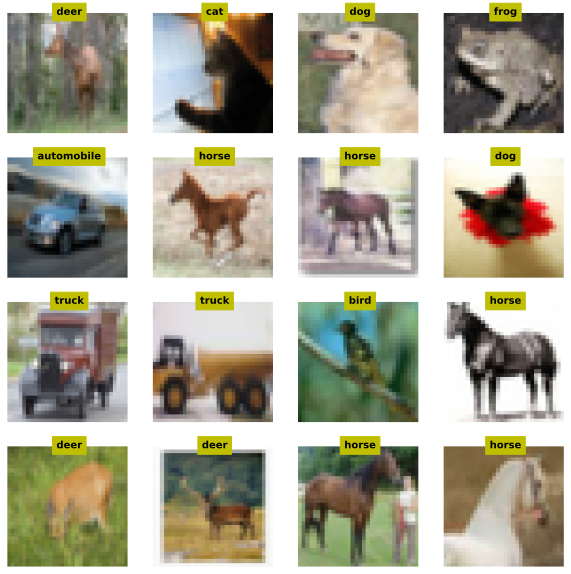

In [27]:
# check for a few random images
fix, axs = plt.subplots(4,4,figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    
    #extract the image (transpose it back to 32x32x3) so matplot can understand it
    pic = X.data[i].numpy().transpose((1,2,0))
    pic = pic / 2 + 0.5 #undo normalization
    
    label = train_data.classes[y[i]]
    
    ax.imshow(pic)
    ax.text(16,0, label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')

In [28]:
# parameters
#inChans  = 3 # RGB
#outChans = 15
#krnSize  = 5 # should be an odd number
#stride   = 1
#padding  = 0

#imsize   = [256,256]

## create the instance
#c = nn.Conv2d         (inChans,outChans,krnSize,stride,padding)
#c = nn.ConvTranspose2d(inChans,outChans,krnSize,stride,padding)

# create an image
#img = torch.rand(1,inChans,imsize[0],imsize[1])

# run convolution and compute its shape
#resimg = c(img)
#empSize = torch.squeeze(resimg).shape

# compute the size of the result according to the formula
#expectSize = np.array([outChans,0,0],dtype=int)
#expectSize[1] = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
#expectSize[2] = np.floor( (imsize[1]+2*padding-krnSize)/stride[1] ) + 1

# check the size of the output
#print(f'Expected size: {expectSize}')
#print(f'Empirical size: {list(empSize)}')

In [29]:
# **) size of transpose convolution formula "to calculate the image size of the transpose convolution"
# **) # of pixels in output image = Stride  * (# of pixels in input image - 1) + # of pixels in kernel height    - 2 * Padding
# **)                       Nh    = Sh      * (Mh                         - 1) + K                               - 2*P
# #
# *) size of convolution formula "to calculate the image size of convolution"
# *) # of pixels in current layer = Floor ( (# of pixels in previous layer  + 2*Padding - # of pixels in kernel height) / Stride ) + 1
# *)                        Nh    = Floor ( ( Mh                            + 2*P       - K                           ) / Sh     ) + 1
# *) expectSize = np.array([outChans, 0, 0], dtype=int)
# *) expectsize[1] = np.floor( (imsize[0] + 2*padding - krnSize) / stride[0] ) + 1
# *) expectsize[2] = np.floor( (imsize[1] + 2*padding - krnSize) / s/tride[1] ) + 1
# #
# 1) Image (channels   X Width  X Height)
# 1) Image (1          X i/p 28 X i/p 28)
# #
# 2) Conv1 (# of feature maps kernels   X o/p Width X o/p Height)
# 2) Conv1 ( 10                         X 26        X 26        ) #lost 1 pixel left & 1 pixel right (1 pixel top & 1 pixel bottom) 
# #
# 3) maxpool1 (# of feature maps kernels X o/p width X o/p Height)
# 3) maxpool1 (10                        X 13        X 13        ) #2x2 maxpool * 26x26 = 13 x 13
# #
# 4) Conv2 (# of feature maps kernels   X o/p Width X o/p Height)
# 4) Conv2 (20                          X 11        X 11        )
# #
# 5) maxpool2 (# of feature maps kernels X o/p width X o/p Height)
# 5) maxpool2 (20                        X 5        X 5        ) #2x2 maxpool * 26x26 = 13 x 13
# #
# 6) ANN layer (1X50)

In [30]:
# Create the Deep Learning Model
def createTheNet(printtoggle=False):
    class cnnClassNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.print = printtoggle
            
            inChans  = 3 # RGB
            outChans = 64 # feature maps # of kernels
            krnSize  = 3 # odd number
            padding  = 1 # square if single input
            stride   = 1 # use maxpool instead of stride ... so stride = 1
            
            # First Convolution Layer
            #Conv2d(in_channels # of channels,
            #       out_channels # feature maps kernels, 
            #       kernel_size, 
            #       stride,
            #       padding  )
            self.conv1  = nn.Conv2d(inChans,outChans,krnSize, padding, stride)
            self.bnorm1 = nn.BatchNorm2d(outChans) # 64
            # output size = np.floor( (imsize[0]+2*padding-krnSize)/stride[0] ) + 1
            # output size = floor( (32 + 2*1 - 3) / 1 ) + 1 = 32
            # output size = 32/2 = 16 b/c of avgpool
            
            # Second Convolution Layer
            self.conv2  = nn.Conv2d(outChans,outChans*2,krnSize, padding=0, stride=stride)
            self.bnorm2 = nn.BatchNorm2d(outChans*2) # 128
            # output size = floor( (16 + 2*0 - 3) / 1 ) + 1 = 14
            # output size = 14/2 = 7 b/c of avgpool

            # Third Convolution Layer
            self.conv3  = nn.Conv2d(outChans*2,outChans*2*2,krnSize, padding=0, stride=stride)
            self.bnorm3 = nn.BatchNorm2d(outChans*2*2) # 256
            # output size = floor( (7 + 2*0 - 3) / 1 ) + 1 = 5
            # output size = 5/2 = 2 b/c of avgpool

            ### ------- Linear Layer ------- ###
            self.fc1 = nn.Linear(256*2*2,256) #1024, 256
            self.fc2 = nn.Linear(256,64)
            self.fc3 = nn.Linear(64,10)
            
        def forward(self, x):
            
            if self.print: print(f'Input: {list(x.shape)}')
            
            #first conv -> maxpool -> batchnorm -> relu
            #CPBR block
            x = F.avg_pool2d( self.conv1(x), 2)
            x = F.leaky_relu( self.bnorm1(x)  )
            if self.print: print(f'First conv: {list(x.shape)}')
            
            x = F.avg_pool2d( self.conv2(x), 2)
            x = F.leaky_relu( self.bnorm2(x)  )
            if self.print: print(f'Second conv: {list(x.shape)}')

            x = F.avg_pool2d( self.conv3(x), 2)
            x = F.leaky_relu( self.bnorm3(x)  )
            if self.print: print(f'Third conv: {list(x.shape)}')

            #reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
            
            # Linear layers
            x = F.leaky_relu( self.fc1(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc1: {list(x.shape)}')
            
            x = F.leaky_relu( self.fc2(x)   )
            x = F.dropout(x, p=0.5, training=self.training)
            if self.print: print(f'fc2: {list(x.shape)}')
            
            x = self.fc3(x)
            if self.print: print(f'Final Output: {list(x.shape)}')
            
            
            return x
        
    modelInstance = cnnClassNet().to(device)
    
    lossfun = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(modelInstance.parameters(), lr=0.01, weight_decay=1e-5)#, betas=(0.9, 0.999), eps=1e-8)
    
    return modelInstance, lossfun, optimizer

In [31]:
#Test with 1 batch
net2, lossfun2, optimizer2 = createTheNet(True)

X, y = next(iter(train_loader))
yHat = net2(X)

#check size of output
print(yHat.shape)

#compute the loss
loss = lossfun2(yHat, torch.squeeze(y))
print(loss)

AttributeError: 'cnnClassNet' object has no attribute 'print'